<a href="https://colab.research.google.com/github/Anjalikrishnasb/Tweet_Emotion_recognition/blob/tweet_emotion_recognition.ipynb/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Setup and imports
#Installing Hugging face's nlp package
#Importing libraries

In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [ ]:
def show_history(h):
  epochs_trained=len(h.history['loss'])
  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.plot(range(0,epochs_trained),h.history.get('accuracy'),label='Training')
  plt.plot(range(0,epochs_trained),h.history.get('val_accuracy'),label='Validation')
  plt.ylim([0.,1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(0,epochs_trained),h.history.get('loss'),label='Training')
  plt.plot(range(0,epochs_trained),h.history.get('val_loss'),label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [ ]:
def show_confusion_matrix(y_true,y_pred,classes):
  from sklearn.metrics import confusion_matrix
  cm=confusion_matrix(y_true,y_pred,normalization='true')
  plt.figure(figsize=(8,8))
  sp=plt.subplot(1,1,1)
  ctx=sp.matshow(cm)
  plt.xticks(list(range(0,6)),labels=classes)
  plt.yticks(list(range(0,6)),label=classes)
  plt.colorbar(ctx)
  plt.show()


In [ ]:
tf.__version__

'2.15.0'

In [ ]:
#Importing data
!pip install datasets

from datasets import load_dataset

ds = load_dataset("dair-ai/emotion", "split")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train =ds['train']
val=ds['validation']
test=ds['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

In [ ]:
#labels
#0-sadness
#1-joy
#2-love
#3-anger
#4-fear
#5-surprise

In [ ]:
#Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#less commonly used words are ignored

In [ ]:
#oov_token-out_of_vocabulary_token
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

In [ ]:
#Padding and truncating sequences

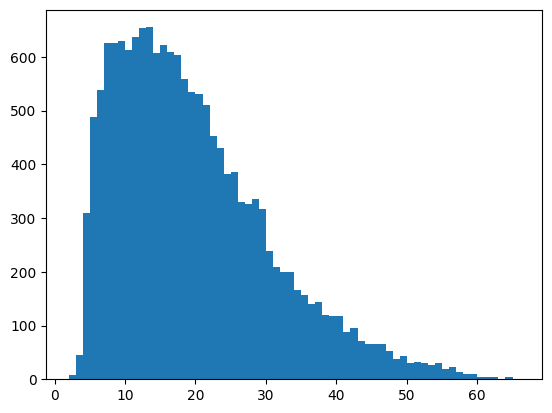

In [ ]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
#Preparing the labels
#Multiclass classification

In [ ]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


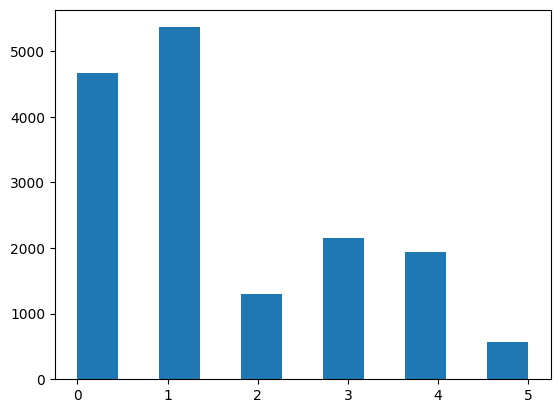

In [ ]:
plt.hist(labels,bins=11)
plt.show()
#class imbalance problem

In [ ]:
train_labels=labels
train_labels[160]

4

In [ ]:
#Creating the model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Training the model

In [ ]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=val_labels
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
import numpy as np
import tensorflow as tf
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]
)

Epoch 1/20
500/500 [==============================] - 46s 61ms/step - loss: 1.2790 - accuracy: 0.4952 - val_loss: 0.8381 - val_accuracy: 0.6655
Epoch 2/20
500/500 [==============================] - 10s 19ms/step - loss: 0.5727 - accuracy: 0.7642 - val_loss: 0.5735 - val_accuracy: 0.7860
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3355 - accuracy: 0.8848 - val_loss: 0.4571 - val_accuracy: 0.8495
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2182 - accuracy: 0.9323 - val_loss: 0.4191 - val_accuracy: 0.8590
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1539 - accuracy: 0.9524 - val_loss: 0.4456 - val_accuracy: 0.8705
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.1213 - accuracy: 0.9624 - val_loss: 0.5282 - val_accuracy: 0.8400
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.1044 - accuracy: 0.9669 - val_loss: 0.4368 - val_accuracy: 0.88

In [ ]:
#Evaluating the model

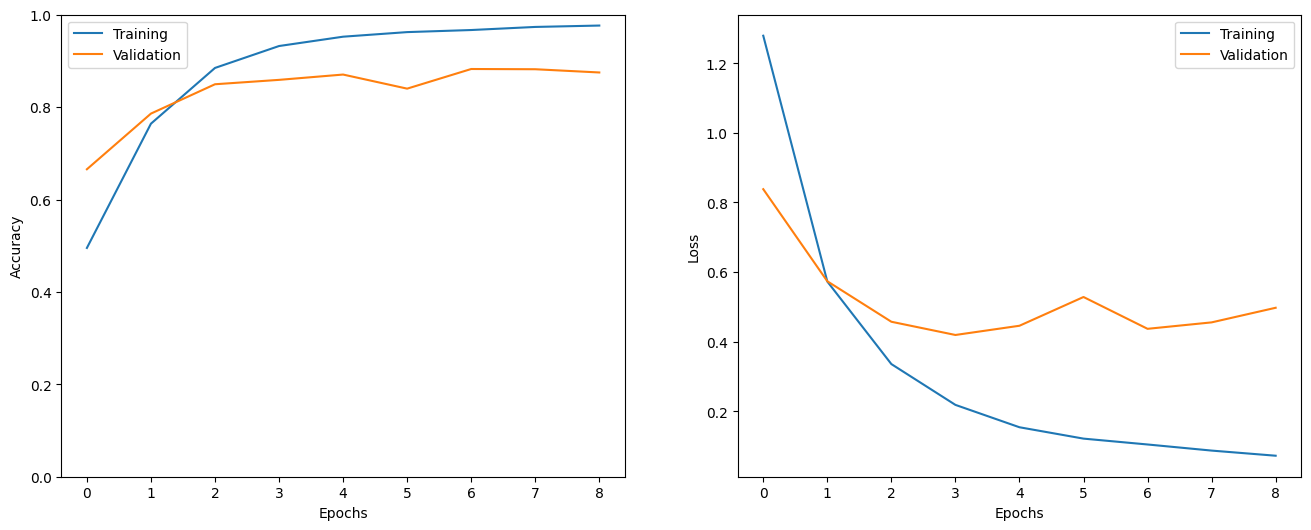

In [ ]:
show_history(h)

In [ ]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=test_labels

In [ ]:

import numpy as np

test_labels = np.array(test_labels)

model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 9ms/step - loss: 0.4557 - accuracy: 0.8785


[0.4557332396507263, 0.8784999847412109]

In [ ]:
i=random.randint(0,len(test_labels)-1)
print("sentence:",test_tweets[i])
print("Emotion:",test_labels[i])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=np.argmax(p).astype('uint8')

print('Predicted emotion:',pred_class)

sentence: i went to training feeling very disheartened
Emotion: 0
1/1 [==============================] - 2s 2s/step
Predicted emotion: 0


In [ ]:
#labels
#0-sadness
#1-joy
#2-love
#3-anger
#4-fear
#5-surprise

In [ ]:
preds=np.argmax(model.predict(test_seq),axis=-1)

63/63 [==============================] - 0s 6ms/step


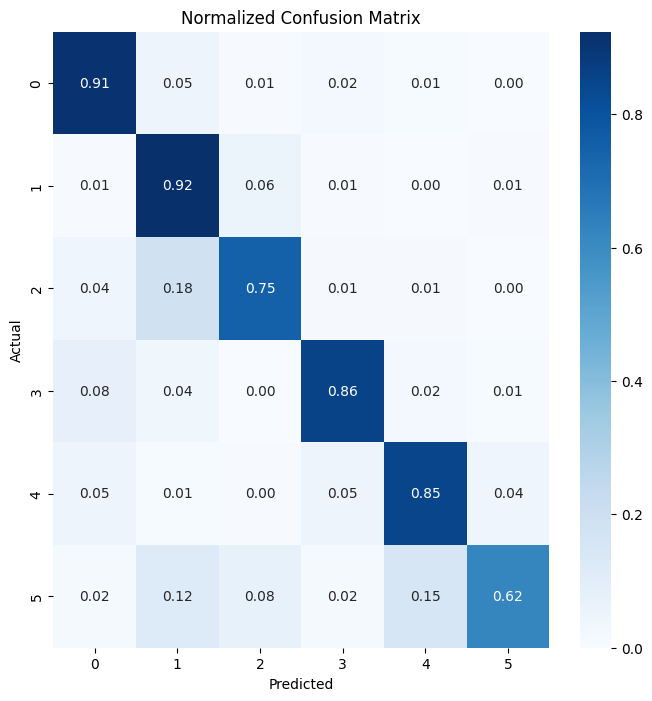

In [ ]:
import seaborn as sns
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
    sp.set_xlabel('Predicted')
    sp.set_ylabel('Actual')
    sp.set_title('Normalized Confusion Matrix')
    plt.show()

show_confusion_matrix(test_labels, preds, classes)